# The Battle of Neighborhoods -  Finding The Right Location For a Gym

# Table of contents

* [1. Introduction](#introduction)
* [2. Import the required libraries](#libraries)
* [3. Download and Explore Dataset](#dataset)
* [4. Use Foursquare Location Data](#foursquare)
* [5. Cluster Neighborhoods](#cluster)
* [6. Examine Clusters](#examination)

# 1. Introduction <a name="introduction"></a>

This project is aimed to help entrepreneurs or business owners, who want to open a Gym in New York City, better choose the right location using the Foursquare API and clustering.

## 2. Import the required libraries <a name="libraries"></a>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # useful for many scientific computing in Python
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install  geopy  # uncomment this line to install geopy if needed.
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage 
from sklearn.cluster import KMeans

#!pip install folium # uncomment this line to install folium if needed.
import folium # map rendering library
import os
import time

#!pip install selenium
from selenium import webdriver

print('Libraries imported.')

Libraries imported.


## 3. Download and Explore Dataset <a name="dataset"></a>

let's download the required data by running a wget command

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
#newyork_data

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a pandas dataframe

Since the data is in a JSON format, we first need to transform it into a _pandas_ dataframe. So let's start by creating an empty dataframe.

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [9]:
neighborhoods=neighborhoods.sort_values(by=['Latitude']).reset_index(drop=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,Tottenville,40.505334,-74.246569
1,Staten Island,Butler Manor,40.506082,-74.229504
2,Staten Island,Richmond Valley,40.519541,-74.229571
3,Staten Island,Pleasant Plains,40.524699,-74.219831
4,Staten Island,Prince's Bay,40.526264,-74.201526


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [10]:
print('The dataframe has {} boroughs, {} neighborhoods and {} latitudes .'.format(
        len(neighborhoods['Borough'].unique()),len(neighborhoods['Neighborhood'].unique()),
    len(neighborhoods['Latitude'].unique())
    )
)

The dataframe has 5 boroughs, 302 neighborhoods and 306 latitudes .


Note that the number of neighborhoods differs from that of latitudes. This is due to the fact that there are neighborhoods with the same name. As an example, a neighborhood of the same name “Bay Terrace” exists in both the Borough of Queens and the Borough of Staten Island. It is therefore preferable to analyze our data by latitude rather than by neighborhood.

#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], 
                                           neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

# save newyork map as an html
map_newyork.save('newyork_map.html')
mapUrl = 'file://{0}/{1}'.format(os.getcwd(), 'newyork_map.html')

# use selenium to save the html as png image
driver = webdriver.Firefox()
driver.get(mapUrl)

# wait for 5 seconds for the maps and other assets to be loaded in the browser
time.sleep(5)
driver.save_screenshot('newyork_map.png')
driver.quit()

map_newyork

## 4. Use Foursquare Location Data <a name='foursquare'></a>

In what follows, we will create a pandas dataframe, using the Foursquare API, that includes the name of neighborhoods within the five boroughs of the City of New York, the latitude and longitude coordinates of each neighborhood and the mean of the frequency of occurrence of both the Gyms and the Burger Joints existing in each neighborhood. This dataframe will be the basis of our analysis.

#### Define Foursquare Credentials and Version


In [12]:
CLIENT_ID = 'Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Foursquare ID
CLIENT_SECRET:Foursquare Secret


#### Now, let's get the top 100 venues that are in each neighborhood within a radius of 5000 meters.

First, let's create a function that returns the venues of each neighborhood in New York City. We already know that all the information is in the items key.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only the name and the categorie of each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Category']
    
#    nearby_venues.to_csv('venues.csv',index=False)
    return(nearby_venues)

Now, let's create a new dataframe called newyork_venues using the above function.

In [14]:
#newyork_venues=getNearbyVenues(neighborhoods['Neighborhood'],neighborhoods['Latitude'],neighborhoods['Longitude'])

In [15]:
newyork_venues=pd.read_csv('venues.csv')

Let's examine the resulting dataframe and check its shape.

In [16]:
print(newyork_venues.shape)
newyork_venues.head()

(30528, 5)


,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Tottenville,40.505334,-74.246569,Conference House Park,Park
1,Tottenville,40.505334,-74.246569,Towne Deli Pizzeria,Pizza Place
2,Tottenville,40.505334,-74.246569,Angelina's Ristorante,Italian Restaurant
3,Tottenville,40.505334,-74.246569,La Bella Marketplace,Grocery Store
4,Tottenville,40.505334,-74.246569,Intoxx Fitness,Gym


Let's check how many venues were returned for each neighborhood.

In [17]:
newyork_venues.groupby('Latitude').count().head(10)

,Neighborhood,Longitude,Venue,Venue Category
Latitude,,,,
40.505334,100,100,100,100
40.506082,100,100,100,100
40.519541,100,100,100,100
40.524699,100,100,100,100
40.526264,100,100,100,100
40.530531,100,100,100,100
40.531912,91,91,91,91
40.538114,97,97,97,97
40.541140,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues.

In [18]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 352 uniques categories.


In [19]:
#print("The Venue Categories are", newyork_venues['Venue Category'].unique())

In [20]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Latitude'] = newyork_venues['Latitude'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Latitude,Accessories Store,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Picnic Shelter,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store

And let's examine the new dataframe size.

In [21]:
print(newyork_onehot.shape)

(30528, 353)


Next, let's group rows by "Latitude" and by taking the mean of the frequency of occurrence of each category.

In [22]:
newyork_grouped = newyork_onehot.groupby('Latitude').mean().reset_index()
newyork_grouped.head()

,Latitude,Accessories Store,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Picnic Shelter,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store

Let's confirm the new size

In [23]:
newyork_grouped.shape

(306, 353)

In [24]:
df_grouped=newyork_grouped[['Latitude', 'Burger Joint', 'Gym']]
print(df_grouped.shape)
df_grouped.head()

(306, 3)


,Latitude,Burger Joint,Gym
0,40.505334,0.00,0.02
1,40.506082,0.00,0.02
2,40.519541,0.00,0.02
3,40.524699,0.00,0.02
4,40.526264,0.01,0.03


#### Now we are ready to create our main dataframe.

In [31]:
main_df=neighborhoods.copy()
main_df[['Burger-Joint Mean Freq', 'Gym Mean Freq']]=df_grouped[['Burger Joint', 'Gym']]
print(main_df.shape)
main_df.head()

(306, 6)


,Borough,Neighborhood,Latitude,Longitude,Burger-Joint Mean Freq,Gym Mean Freq
0,Staten Island,Tottenville,40.505334,-74.246569,0.00,0.02
1,Staten Island,Butler Manor,40.506082,-74.229504,0.00,0.02
2,Staten Island,Richmond Valley,40.519541,-74.229571,0.00,0.02
3,Staten Island,Pleasant Plains,40.524699,-74.219831,0.00,0.02
4,Staten Island,Prince's Bay,40.526264,-74.201526,0.01,0.03


## 5. Cluster Neighborhoods <a name='cluster'></a>

Before using k-means clustering we first need to find the optimal number of clusters "k". So, let's apply the Elbow Point method using Inertia.

In [29]:
def get_inertia(k_clusters, data):
    kmean = KMeans(n_clusters=k_clusters, init='k-means++', max_iter=10, random_state=0)
    kmean.fit(data)
    return kmean.inertia_, kmean.labels_

In [33]:
inertia1 = [get_inertia(k, main_df[['Gym Mean Freq']])[0] for k in range(1, 12)]
inertia2 = [get_inertia(k, main_df[['Burger-Joint Mean Freq']])[0] for k in range(1, 12)]

<ipython-input-29-ea257635e77e>:3: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmean.fit(data)
<ipython-input-29-ea257635e77e>:3: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  kmean.fit(data)


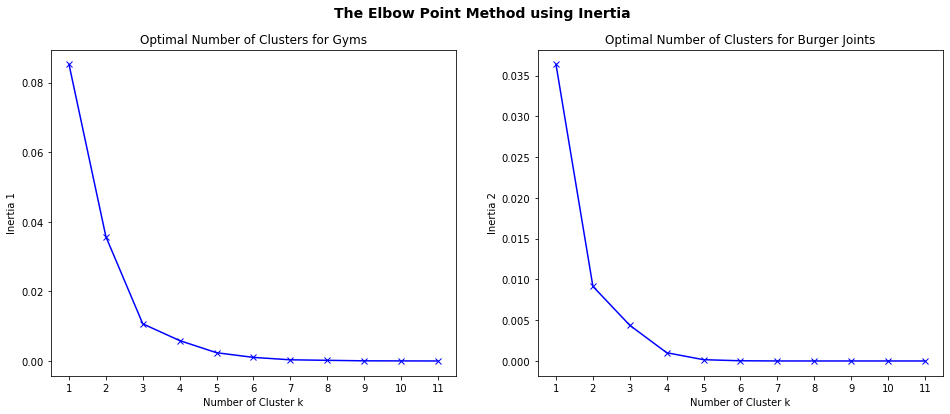

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

ax1.set_xlabel('Number of Cluster k')
ax1.set_ylabel('Inertia 1')
ax1.set_xticks(range(1, 12))
ax1.set_title('Optimal Number of Clusters for Gyms')
ax1.plot(range(1, 12), inertia1, 'bx-')

ax2.set_xlabel('Number of Cluster k')
ax2.set_ylabel('Inertia 2')
ax2.set_xticks(range(1, 12))
ax2.set_title('Optimal Number of Clusters for Burger Joints')
ax2.plot(range(1, 12), inertia2, 'bx-')

plt.suptitle(("The Elbow Point Method using Inertia"), fontsize=14, fontweight='bold')

plt.show()

We see that the decreases in inertia 1 and inertia 2 begin to slow at k=4. Hence, grouped Gyms and Burger Joints into 4 clusters is the right option.

In [35]:
# run k-means to cluster the neighborhoods into 4 clusters.
main_df['Gym Cluster']= get_inertia(4, main_df[['Gym Mean Freq']])[1]
main_df['Burger-Joint Cluster']= get_inertia(4, main_df[['Burger-Joint Mean Freq']])[1]

# move Burger-Joint Cluster column to the sixt column
fixed_columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude','Burger-Joint Mean Freq',
               'Burger-Joint Cluster', 'Gym Mean Freq', 'Gym Cluster']

main_df = main_df[fixed_columns]

In [36]:
main_df.head()

,Borough,Neighborhood,Latitude,Longitude,Burger-Joint Mean Freq,Burger-Joint Cluster,Gym Mean Freq,Gym Cluster
0,Staten Island,Tottenville,40.505334,-74.246569,0.00,2,0.02,0
1,Staten Island,Butler Manor,40.506082,-74.229504,0.00,2,0.02,0
2,Staten Island,Richmond Valley,40.519541,-74.229571,0.00,2,0.02,0
3,Staten Island,Pleasant Plains,40.524699,-74.219831,0.00,2,0.02,0
4,Staten Island,Prince's Bay,40.526264,-74.201526,0.01,0,0.03,1


Let's visualize the resulting clusters for both the Burger-Joint Clusters and the Gym clusters.

In [37]:
# set the geographical coordinates of  New York City
latlng = [40.7127281, -74.0060152] 
# create map
map_burger_clusters = folium.Map(location=latlng, zoom_start=10)
# set color scheme for the Burger-Joint Clusters
#nbr_clusters=4
#colors_array = cm.rainbow(np.linspace(0, 1, nbr_clusters))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow=['#FF0000', '#FFFF00','#008000', '#0000FF']
# add markers to the map
X = (main_df['Latitude'], main_df['Longitude'], main_df['Neighborhood'], main_df['Borough'],
                                                                         main_df['Burger-Joint Cluster'])
for lat, lng, neighborhood, borough, cluster in zip(X[0],X[1],X[2],X[3], X[4]):
    label = folium.Popup(str(neighborhood) +'\n'+ str(borough) +'\n' +' Cluster'+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_burger_clusters)
    
# create a legend on the burger clusters map
html_itms=[]
items=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
for itm, col in zip(items, rainbow):
    item_txt="""<br> &nbsp; {item} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{col}"></i>"""
    html_itms.append(item_txt.format( item= itm , col= col))

legend_html = """
     <div style="
     position: fixed; 
     top: 10px; right: 10px; width: 110px; height: 160px;  
     border:2px solid grey; z-index:9999;
     
     background-color:white;
     opacity: .85;
     
     font-size:13px;
     font-weight: bold;
     
     ">
     &nbsp; {title} 
     
     {itm_txt0}
     {itm_txt1}
     {itm_txt2}
     {itm_txt3}

      </div> """.format( title = "Burger Cluster", itm_txt0= html_itms[0], itm_txt1= html_itms[1],
                       itm_txt2= html_itms[2], itm_txt3= html_itms[3])
map_burger_clusters.get_root().html.add_child(folium.Element( legend_html )) 

# save burger clusters map as an html
map_burger_clusters.save('burger_clusters_map.html')

# use selenium to save the html as png image
mapUrl = 'file://{0}/{1}'.format(os.getcwd(), 'burger_clusters_map.html')
driver = webdriver.Firefox()
driver.get(mapUrl)

# wait for 5 seconds for the maps and other assets to be loaded in the browser
time.sleep(5)
driver.save_screenshot('burger_clusters_map.png')
driver.quit()
    
map_burger_clusters

In [39]:
# set the geographical coordinates of  New York City
latlng = [40.7127281, -74.0060152] 
# create map
map_gym_clusters = folium.Map(location=latlng, zoom_start=10)

# add markers to the map
X = (main_df['Latitude'], main_df['Longitude'], main_df['Neighborhood'], main_df['Borough'],
                                                                         main_df['Gym Cluster'])
for lat, lng, neighborhood, borough, cluster in zip(X[0],X[1],X[2],X[3], X[4]):
    label = folium.Popup(str(neighborhood) +'\n'+ str(borough) +'\n' +' Cluster'+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_gym_clusters)

# create a legend on the gym clusters map
html_itms=[]
items=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
for itm, col in zip(items, rainbow):
    item_txt="""<br> &nbsp; {item} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{col}"></i>"""
    html_itms.append(item_txt.format( item= itm , col= col))

legend_html = """
     <div style="
     position: fixed; 
     top: 10px; right: 10px; width: 110px; height: 160px; 
     border:2px solid grey; z-index:9999; 
     
     background-color:white;
     opacity: .85;
     
     font-size:13px;
     font-weight: bold;
     
     ">
     &nbsp; {title} 
     
     {itm_txt0}
     {itm_txt1}
     {itm_txt2}
     {itm_txt3}

      </div> """.format( title = "Gym Cluster", itm_txt0= html_itms[0], itm_txt1= html_itms[1],
                       itm_txt2= html_itms[2], itm_txt3= html_itms[3])
map_gym_clusters.get_root().html.add_child(folium.Element( legend_html )) 

# save burger clusters map as an html
map_gym_clusters.save('gym_clusters_map.html')

# use selenium to save the html as png image
mapUrl = 'file://{0}/{1}'.format(os.getcwd(), 'gym_clusters_map.html')
driver = webdriver.Firefox()
driver.get(mapUrl)

# wait for 5 seconds for the maps and other assets to be loaded in the browser
time.sleep(5)
driver.save_screenshot('gym_clusters_map.png')
driver.quit()
        
map_gym_clusters

## 6. Examine Clusters <a name='examination'></a>

Now, we are ready to examine the obtained clusters.

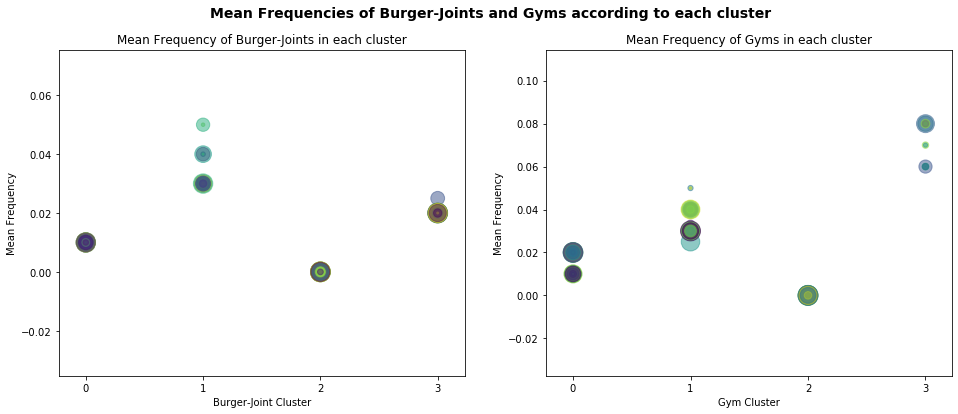

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

# Fixing random state for reproducibility
np.random.seed(19680801)

x1=main_df['Burger-Joint Cluster']
y1=main_df['Burger-Joint Mean Freq']
colors1 = np.random.rand(len(x1))
area1 = (20* np.random.rand(len(x1)))**2

ax1.set_xlabel('Burger-Joint Cluster')
ax1.set_ylabel('Mean Frequency')
ax1.set_xticks(range(0, 4))
ax1.set_title('Mean Frequency of Burger-Joints in each cluster')
ax1.scatter(x1, y1, s=area1, c=colors1, alpha=0.5)

x2=main_df['Gym Cluster']
y2=main_df['Gym Mean Freq']
colors2 = np.random.rand(len(x1))
area2 = (20* np.random.rand(len(x1)))**2

ax2.set_xlabel('Gym Cluster')
ax2.set_ylabel('Mean Frequency')
ax2.set_xticks(range(0, 4))
ax2.set_title('Mean Frequency of Gyms in each cluster')
ax2.scatter(x2, y2, s=area2, c=colors2, alpha=0.5)

plt.suptitle(("Mean Frequencies of Burger-Joints and Gyms according to each cluster"), fontsize=14, fontweight='bold')

plt.show()

Let's create dataframes including the number of neighborhoods that exist in each cluster and the average of each cluster.

In [41]:
# define the dataframes columns
column_names= ['Number of Neighborhoods', 'Average'] 

# instantiate the dataframes
burger_cluster = pd.DataFrame(columns=column_names)
gym_cluster = pd.DataFrame(columns=column_names)

In [43]:
for cluster in range(0,4):
    df1=main_df[main_df['Burger-Joint Cluster'] == cluster] 
    df2=main_df[main_df['Gym Cluster'] == cluster] 
    
    burger_cluster = burger_cluster.append({'Number of Neighborhoods': df1['Neighborhood'].count(),
                                          'Average': df1['Burger-Joint Mean Freq'].mean()}, ignore_index=True)
    gym_cluster = gym_cluster.append({'Number of Neighborhoods': df2['Neighborhood'].count(),
                                          'Average': df2['Gym Mean Freq'].mean()}, ignore_index=True)
    
index1={0:'Burger Cluster 0',1:'Burger Cluster 1',2:'Burger Cluster 2',3:'Burger Cluster 3'}
index2={0:'Gym Cluster 0',1:'Gym Cluster 1',2:'Gym Cluster 2',3:'Gym Cluster 3'}

burger_cluster=burger_cluster.rename(index=index1)
gym_cluster=gym_cluster.rename(index=index2)

burger_cluster['Number of Neighborhoods']=burger_cluster['Number of Neighborhoods'].astype('int64')
gym_cluster['Number of Neighborhoods']=gym_cluster['Number of Neighborhoods'].astype('int64')

Quickly examine the resulting dataframes.

In [44]:
burger_cluster

,Number of Neighborhoods,Average
Burger Cluster 0,77,0.010000
Burger Cluster 1,30,0.032667
Burger Cluster 2,126,0.000000
Burger Cluster 3,73,0.020088


In [45]:
gym_cluster

,Number of Neighborhoods,Average
Gym Cluster 0,140,0.015473
Gym Cluster 1,37,0.033729
Gym Cluster 2,116,0.000000
Gym Cluster 3,13,0.070769


Finally, let's create a dataframe containing all common two-by-two neighborhoods between clusters.

In [46]:
# define the dataframes columns
column_names= ['Gym Cluster 0', 'Gym Cluster 1', 'Gym Cluster 2', 'Gym Cluster 3'] 

# instantiate the dataframes
inter_cluster = pd.DataFrame(columns=column_names)

In [47]:
for cluster1 in range(0,4):
    df1=main_df[main_df['Burger-Joint Cluster'] == cluster1]['Latitude'] 
    len_cluster_merged=[]
    for cluster2 in range(0,4): 
        df2=main_df[main_df['Gym Cluster'] == cluster2]['Latitude'] 
        
        # combine data on common  indices
        cluster_merged=pd.merge(df1, df2)
        len_cluster_merged.append(len(cluster_merged))
        
    inter_cluster=inter_cluster.append({'Gym Cluster 0': len_cluster_merged[0],
                                        'Gym Cluster 1': len_cluster_merged[1],
                                        'Gym Cluster 2': len_cluster_merged[2],
                                        'Gym Cluster 3': len_cluster_merged[3]}, ignore_index=True)
    
index={0:'Burger Cluster 0', 1:'Burger Cluster 1', 2:'Burger Cluster 2',3:'Burger Cluster 3'}
inter_cluster=inter_cluster.rename(index=index)

In [48]:
inter_cluster

,Gym Cluster 0,Gym Cluster 1,Gym Cluster 2,Gym Cluster 3
Burger Cluster 0,40,11,26,0
Burger Cluster 1,10,4,16,0
Burger Cluster 2,55,18,40,13
Burger Cluster 3,35,4,34,0


And make sure that the sum of all the values in the dataframe is equal the number of neighborhoods (306).

In [49]:
inter_cluster.sum().sum()

306